In [1]:
import pandas as pd
import numpy as np
import tqdm

In [2]:
df = pd.read_csv('balanced-all.csv')

In [3]:
df.head()

,filename,gender
0,data/cv-other-train/sample-069205.npy,female
1,data/cv-valid-train/sample-063134.npy,female
2,data/cv-other-train/sample-080873.npy,female
3,data/cv-other-train/sample-105595.npy,female
4,data/cv-valid-train/sample-144613.npy,female


In [4]:
print("Total number of samples: ",len(df))
print("Total male samples: ", len(df[df['gender']=='male']))
print("Total female samples: ", len(df[df['gender']=='female']))

Total number of samples:  66938
Total male samples:  33469
Total female samples:  33469


In [5]:
import seaborn as sns

<AxesSubplot:xlabel='gender', ylabel='count'>

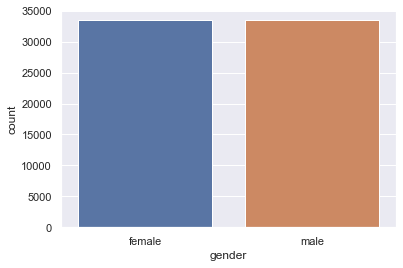

In [6]:
sns.set(rc={'figure.figsize':(15, 5)})
sns.countplot(x="gender", 
        data=df)


In [7]:
label2int = {
    "male": 1,
    "female": 0
}

def load_data(vector_length=128):
    if not os.path.isdir("results"):
        os.mkdir("results")
    if os.path.isfile("results/features.npy") and os.path.isfile("results/labels.npy"):
        X = np.load("results/features.npy")
        y = np.load("results/labels.npy")
        return X, y
    # read dataframe
    df = pd.read_csv("balanced-all.csv")
    # get total samples
    n_samples = len(df)
    # get total male samples
    n_male_samples = len(df[df['gender'] == 'male'])
    # get total female samples
    n_female_samples = len(df[df['gender'] == 'female'])
    print("Total samples:", n_samples)
    print("Total male samples:", n_male_samples)
    print("Total female samples:", n_female_samples)
    # initialize an empty array for all audio features
    X = np.zeros((n_samples, vector_length))
    # initialize an empty array for all audio labels (1 for male and 0 for female)
    y = np.zeros((n_samples, 1))
    for i, (filename, gender) in tqdm.tqdm(enumerate(zip(df['filename'], df['gender'])), "Loading data", total=n_samples):
        features = np.load(filename)
        X[i] = features
        y[i] = label2int[gender]
    np.save("results/features", X)
    np.save("results/labels", y)
    return X, y

In [8]:
def split_data(X, y, test_size=0.1, valid_size=0.1):
    # split training set and testing set
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=7)
    # split training set and validation set
    X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=valid_size, random_state=7)
    # return a dictionary of values
    return {
        "X_train": X_train,
        "X_valid": X_valid,
        "X_test": X_test,
        "y_train": y_train,
        "y_valid": y_valid,
        "y_test": y_test
    }

In [9]:
import os
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard, EarlyStopping
from sklearn.model_selection import train_test_split

In [10]:
X, y = load_data()
# split the data into training, validation and testing sets
data = split_data(X, y, test_size=0.1, valid_size=0.1)

In [11]:
def create_model(vector_length=128):
    """5 hidden dense layers from 256 units to 64, not the best model."""
    model = Sequential()
    model.add(Dense(256, input_shape=(vector_length,)))
    model.add(Dropout(0.3))
    model.add(Dense(256, activation="relu"))
    model.add(Dropout(0.3))
    model.add(Dense(128, activation="relu"))
    model.add(Dropout(0.3))
    model.add(Dense(128, activation="relu"))
    model.add(Dropout(0.3))
    model.add(Dense(64, activation="relu"))
    model.add(Dropout(0.3))
    # one output neuron with sigmoid activation function, 0 means female, 1 means male
    model.add(Dense(1, activation="sigmoid"))
    # using binary crossentropy as it's male/female classification (binary)
    model.compile(loss="binary_crossentropy", metrics=["accuracy"], optimizer="adam")
    # print summary of the model
    model.summary()
    return model

In [12]:
model = create_model()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 256)               33024     
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 256)               65792     
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_2 (Dense)             (None, 128)               32896     
                                                                 
 dropout_2 (Dropout)         (None, 128)               0         
                                                                 
 dense_3 (Dense)             (None, 128)               1

In [13]:
tensorboard = TensorBoard(log_dir="logs")
# define early stopping to stop training after 5 epochs of not improving
early_stopping = EarlyStopping(mode="min", patience=5, restore_best_weights=True)

batch_size = 64
epochs = 100
model.fit(data["X_train"], data["y_train"], epochs=epochs, batch_size=batch_size, validation_data=(data["X_valid"], data["y_valid"]),
          callbacks=[tensorboard, early_stopping])

Epoch 1/100
848/848 [==============================] - 4s 3ms/step - loss: 0.5729 - accuracy: 0.7609 - val_loss: 0.3929 - val_accuracy: 0.8413
Epoch 2/100
848/848 [==============================] - 3s 3ms/step - loss: 0.4205 - accuracy: 0.8325 - val_loss: 0.3323 - val_accuracy: 0.8667
Epoch 3/100
848/848 [==============================] - 3s 3ms/step - loss: 0.3855 - accuracy: 0.8484 - val_loss: 0.3164 - val_accuracy: 0.8699
Epoch 4/100
848/848 [==============================] - 3s 3ms/step - loss: 0.3621 - accuracy: 0.8594 - val_loss: 0.3134 - val_accuracy: 0.8727
Epoch 5/100
848/848 [==============================] - 3s 4ms/step - loss: 0.3467 - accuracy: 0.8664 - val_loss: 0.2959 - val_accuracy: 0.8873
Epoch 6/100
848/848 [==============================] - 3s 3ms/step - loss: 0.3405 - accuracy: 0.8712 - val_loss: 0.2961 - val_accuracy: 0.8866
Epoch 7/100
848/848 [==============================] - 3s 3ms/step - loss: 0.3282 - accuracy: 0.8746 - val_loss: 0.2811 - val_accuracy: 0.8948

In [14]:
print(f"Evaluating the model using {len(data['X_test'])} samples...")
loss, accuracy = model.evaluate(data["X_test"], data["y_test"], verbose=0)
print(f"Loss: {loss:.4f}")
print(f"Accuracy: {accuracy*100:.2f}%")

Evaluating the model using 6694 samples...
Loss: 0.2265
Accuracy: 91.66%


In [15]:
model.save("results/model.h5")

In [16]:
# import pyaudio
# import os
# import wave
# from array import array
# from sys import byteorder
# from struct import pack

# def record(outputfile):
#     CHUNK = 1024
#     FORMAT = pyaudio.paInt16
#     CHANNELS = 2
#     RATE = 44100
#     RECORD_SECONDS = 10

#     p = pyaudio.PyAudio()
#     stream = p.open(format=FORMAT,
#     channels=CHANNELS,
#     rate=RATE,
#     input=True,
#     frames_per_buffer=CHUNK)

#     print("Recording......")

#     frames = []

#     for i in range(0,int(RATE/CHUNK*RECORD_SECONDS)):
#         data = stream.read(CHUNK)
#         frames.append(data)
    
#     print("Done Recording...")

#     stream.stop_stream()
#     stream.close()
#     p.terminate()

#     wf = wave.open(outputfile,'wb')
#     wf.setnchannels(CHANNELS)
#     wf.setsampwidth(p.get_sample_size(FORMAT))
#     wf.setframerate(RATE)
#     wf.writeframes(b''.join(frames))
#     wf.close()

# # record('output1.wav')



In [17]:
def extract_feature(file_name, **kwargs):
    """
    Extract feature from audio file `file_name`
        Features supported:
            - MFCC (mfcc)
            - Chroma (chroma)
            - MEL Spectrogram Frequency (mel)
            - Contrast (contrast)
            - Tonnetz (tonnetz)
    """
    mfcc = kwargs.get("mfcc")
    chroma = kwargs.get("chroma")
    mel = kwargs.get("mel")
    contrast = kwargs.get("contrast")
    tonnetz = kwargs.get("tonnetz")
    X, sample_rate = librosa.core.load(file_name)
    if chroma or contrast:
        stft = np.abs(librosa.stft(X))
    result = np.array([])
    if mfcc:
        mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=40).T, axis=0)
        result = np.hstack((result, mfccs))
    if chroma:
        chroma = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T,axis=0)
        result = np.hstack((result, chroma))
    if mel:
        mel = np.mean(librosa.feature.melspectrogram(X, sr=sample_rate).T,axis=0)
        result = np.hstack((result, mel))
    if contrast:
        contrast = np.mean(librosa.feature.spectral_contrast(S=stft, sr=sample_rate).T,axis=0)
        result = np.hstack((result, contrast))
    if tonnetz:
        tonnetz = np.mean(librosa.feature.tonnetz(y=librosa.effects.harmonic(X), sr=sample_rate).T,axis=0)
        result = np.hstack((result, tonnetz))
    return result

In [19]:
import librosa
model = create_model()

model.load_weights("results/model.h5")
# extract features and reshape it
features = extract_feature('output3.wav', mel=True).reshape(1, -1)
# predict the gender
male_prob = model.predict(features)[0][0]
female_prob = 1 - male_prob
gender = "male" if male_prob > female_prob else "female"
# show the result
print("Result:", gender)
print(f"Probabilities::: Male: {male_prob*100:.2f}%    Female: {female_prob*100:.2f}%")

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_12 (Dense)            (None, 256)               33024     
                                                                 
 dropout_10 (Dropout)        (None, 256)               0         
                                                                 
 dense_13 (Dense)            (None, 256)               65792     
                                                                 
 dropout_11 (Dropout)        (None, 256)               0         
                                                                 
 dense_14 (Dense)            (None, 128)               32896     
                                                                 
 dropout_12 (Dropout)        (None, 128)               0         
                                                                 
 dense_15 (Dense)            (None, 128)              

C:\Users\PC\AppData\Local\Temp\ipykernel_868\1908479891.py:29: FutureWarning: Pass y=[-3.5229730e-06 -9.4623101e-06 -3.3905148e-06 ...  3.0257091e-02
  3.3409148e-02  4.0582184e-02] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(X, sr=sample_rate).T,axis=0)


Result: male
Probabilities::: Male: 96.24%    Female: 3.76%
